In [11]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [12]:

import pandas as pd
sensor_names = pd.read_parquet("../data/pivot_data_hourly.parquet").columns

X_test_seq = np.load("../data/X_test_seq.npy")
Y_test_seq = np.load("../data/Y_test_seq.npy")


test_dataset = TimeSeriesDataset(X_test_seq, Y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size=X_test_seq.shape[2], output_size=Y_test_seq.shape[1], hidden_size=512, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [15]:
model = LSTMModel().to(device)
model.load_state_dict(torch.load("../models/neural_networks/lstm_model.pth"))


<All keys matched successfully>

 Senzor SSA 3 Lysimeter UMP 120cm %: RMSE = 0.3981, R² = 0.4922
 Senzor SSA 3 Lysimeter UMP 30cm %: RMSE = 0.3828, R² = 0.1502
 Senzor SSA 3 Lysimeter UMP 75cm %: RMSE = 0.2102, R² = 0.5756
 Senzor SSA 3 Lysimeter battery V: RMSE = 0.4694, R² = 0.6143
 Senzor SSA 3 Lysimeter ec 120cm mS/cm: RMSE = 0.5530, R² = -0.1331
 Senzor SSA 3 Lysimeter ec 30cm mS/cm: RMSE = 0.3893, R² = 0.7755
 Senzor SSA 3 Lysimeter ec 75cm mS/cm: RMSE = 0.3720, R² = 0.4948
 Senzor SSA 3 Lysimeter scale (1) kg: RMSE = 0.2969, R² = 0.6139
 Senzor SSA 3 Lysimeter temperature 120cm degC: RMSE = 0.1911, R² = 0.8070
 Senzor SSA 3 Lysimeter temperature 30cm degC: RMSE = 0.3140, R² = 0.5437
 Senzor SSA 3 Lysimeter temperature 75cm degC: RMSE = 0.2527, R² = 0.6810
 Senzor SSA 3 Lysimeter tension 120cm kPa: RMSE = 0.3361, R² = -7.4064
 Senzor SSA 3 Lysimeter tension 30cm kPa: RMSE = 0.2563, R² = 0.4625
 Senzor SSA 3 Lysimeter tension 75cm kPa: RMSE = 0.2265, R² = -0.3798
 Senzor SSA 3 Lysimeter vacuum 120cm kPa: RMSE = 0

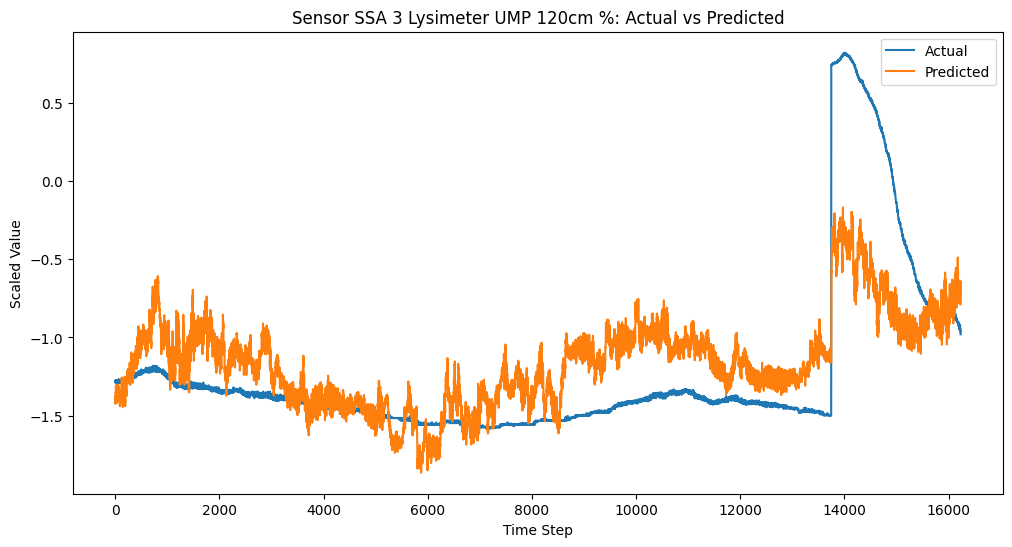

In [16]:
import numpy as np

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate results
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

from sklearn.metrics import r2_score

mse_per_sensor = np.mean((actuals - predictions) ** 2, axis=0)
for idx, loss in enumerate(mse_per_sensor):
    rmse = np.sqrt(loss)
    r2 = r2_score(actuals[:, idx], predictions[:, idx])
    print(f" Senzor {sensor_names[idx]}: RMSE = {rmse:.4f}, R² = {r2:.4f}")
    
sensor_idx = 0  # Change this index to plot a different sensor

plt.figure(figsize=(12, 6))
plt.plot(actuals[:, sensor_idx], label='Actual')
plt.plot(predictions[:, sensor_idx], label='Predicted')
plt.title(f'Sensor {sensor_names[sensor_idx]}: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()
